# Detección de Anomalías en Series de Tiempo
Las series de tiempo están comúnmente en nuestro entorno. Podemos mencionar ejemplos como el precio diario del petróleo, mediciones de variables ambiente, etc. Las series de tiempo son evidentes en todas las industrias de alguna manera.

Debido a su popularidad, es uno de los tipos de datos más investigados. Como generalidad, una serie de tiempo se caracteriza porque las mediciones se realizan en intervalos de tiempo fijos, por ejemplo, cada 15 minutos, cada hora, etc. Dada la periodicidad de las mediciones, los registros están correlacionados en el tiempo.

Mientras analizamos las series de tiempo, debemos dar cuenta de los valores atípicos o anómalos. Se puede decir que un valor anómalo es una observación que se desvía tanto de otras observaciones como para despertar la sospecha de que ha sido generada por un mecanismo diferente.

Los valores anómalos en las series de tiempo pueden ser interpretados principalmente de dos formas: como un dato no esperado o como un evento de interés. La distinción entre estos dos tipos de datos se basa principalmente en el interés particular del analista o del escenario de análisis.

Estas observaciones relacionadas con ruido, datos erróneos o no esperados, que en sí mismos no son de interés para el analista, deben ser eliminadas o corregidas para mejorar la calidad de los datos. Se debe tener en cuenta que estas tareas de limpieza de datos se ejecutan para poder utilizar la el conjunto de datos con otros algoritmos.

El otro punto de vista, se refiere a la tarea de detectar y analizar fenómenos inusuales, pero interesantes. Un buen ejemplo es la detección de fraude, donde el objetivo principal es detectar y analizar el propio fenómeno anómalo.

El problema de la detección de anomalías en las series temporales suele formularse como la identificación de puntos de datos atípicos en relación con alguna norma o señal habitual. Veamos algunos tipos de valores atípicos:

- Valor atípico puntual: un valor atípico puntual es un dato que se comporta de forma inusual en un momento determinado cuando se compara con los demás valores de una serie temporal (outlier global), o con sus puntos vecinos (outlier local).
- Valor atípico subsecuente: Se trata de puntos consecutivos en el tiempo cuyo comportamiento en conjunto es inusual, aunque cada valor por separado no es un necesariamente un valor atípico puntual. Los valores atípico subsecuentes pueden ser locales o globales y también pueden afectar a una (valor atípico subsecuente univariante) o más (valor atípico subsecuente multivariante) variables dependientes del tiempo.

Hay algunas técnicas que los analistas pueden utilizar para detectar diferentes valores anómalos en series de tiempo. Vamos a ver algunas de ellas, sin embargo, primero debemos cargar todas las librerías que usaremos:

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from adtk.visualization import plot
from adtk.data import validate_series

En este caso vamos a utilizar un conjunto de datos real, se trata de mediciones de temperatura de un sensor. Utilizando pandas leemos un archivo csv, donde el delimitador es “;” y adicionalmente indicamos los nombres de las columnas de datos. Estas mediciones tienen un periodo de muestreo de 10 minutos, que utilizaremos como índice. Eliminamos la columna "muestra", pues estos datos ya están en el indice del DataFrame.

In [2]:
data = pd.read_csv('TEMP_selected.csv', names=['muestra','temp'], delimiter=';')
data = data.drop(data.index[[0]])
data.set_index(
    pd.PeriodIndex(np.array(data.muestra), freq="10min"),
    inplace=True,
)
data.drop("muestra", axis=1, inplace=True)

En los datos de temperatura el indicador de decimales originalmente viene “,” necesitamos reemplazarlo por “.”. Posteriormente, podemos convertir estos datos a número flotante.

Adicionalmente, debemos convertir el índice de tiempo a un formato estándar. Utilizamos la conversión a time stamp. Podemos graficar la serie de tiempo.

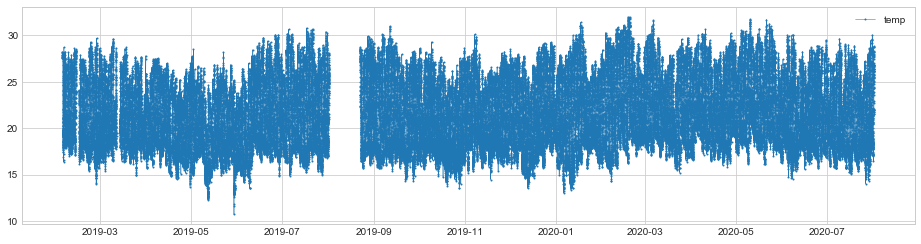

In [3]:
data['temp']= data['temp'].str.replace(',','.')
data['temp']= data['temp'].astype(float)

data.index = data.index.to_timestamp()

plot(data)

En la serie de tiempo podemos observar varios datos no graficados. Estos son datos NaN, inicialmente vamos a rellenar estos valores con 0. Y verificaremos si tenemos datos nulos adicionales. Graficaremos nuevamente la serie de tiempo y haremos una copia de los datos originales. Podemos esperar que los datos que hemos rellenado con 0 sean detectados como anomalías en la mayoría de los casos, vamos a ver como funcionan los algoritmos explorados.

0


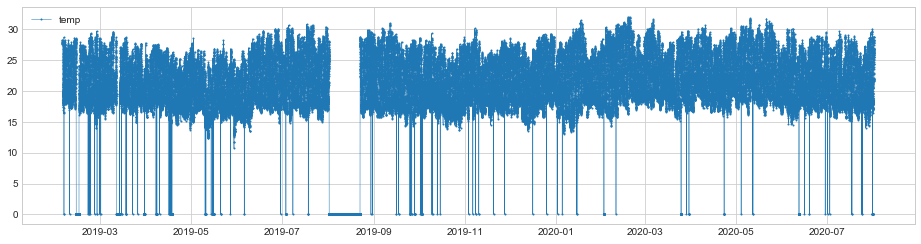

In [4]:
data['temp'] = data['temp'].fillna(0)

print(data['temp'].isnull().sum())

data = validate_series(data)

plot(data)

orig_data = data.copy()

## Árboles de Decisión: Isolation Forest
Podemos utilizar la potencia y la solidez de los árboles de decisión para identificar valores atípicos/anómalos en datos de series tiempo.
-	Podemos utilizar aprendizaje supervisado para enseñar a los arboles de decisión a clasificar los datos anómalos y no anómalos. Para lograr esto, debemos tener los puntos de datos anómalos etiquetados, lo cual no nos encontraremos comúnmente.
-	La otra alternativa más realista es el aprendizaje no supervisado. Para esto podemos utilizar el algoritmo Isolation Forest para predecir cuando un punto se considera anómalo, sin la necesidad de tener un conjunto de datos etiquetado.

La idea principal es que el algoritmo Isolation Forest identifica explícitamente anomalías en lugar de perfilar los puntos de datos normales. Este algoritmo se basa en los árboles de decisión.

El algoritmo IsolationForest "aísla" las observaciones seleccionando aleatoriamente una característica y, a continuación, seleccionando aleatoriamente un valor de partición entre los valores máximo y mínimo de la característica seleccionada.

Dado que la partición recursiva puede representarse mediante una estructura de árbol, el número de divisiones necesarias para aislar una muestra es equivalente a la longitud del camino desde el nodo raíz hasta el nodo final.

Esta longitud del camino, promediada sobre un bosque de tales árboles aleatorios, es una medida de normalidad y nuestra función de decisión.

La partición aleatoria produce caminos notablemente más cortos para las anomalías. Por lo tanto, cuando un bosque de árboles aleatorios produce colectivamente trayectorias más cortas para determinadas muestras, es muy probable que se trate de anomalías.

Isolation Forest detecta anomalías basándose puramente en el hecho de que las anomalías son menos y diferentes. El aislamiento de las anomalías se realiza sin utilizar ninguna distancia o medida de densidad. 
Cuando utilizamos el algoritmo Isolation Forest debemos definir el parámetro outlier_fraction. Este indica al modelo cual es la proporción de anomalías presente en los datos. Es un parámetro que se debe afinar mediante pruebas.

Primero vamos a importar la implementación del algoritmo Isolation Forest de SciKit Learn. Vamos a tomar los datos originales y el índice de los datos para su posterior uso. Indicamos la fracción de datos anómalos que hay en el conjunto; recordemos que este parámetro se debe ajustar de acuerdo con los resultados obtenidos.

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

data = orig_data.copy()
orig_index = data.index

outlier_frac= 0.05

Con el objetivo de obtener mejores resultados, vamos a normalizar los datos entre (-1,1). Para esto utilizaremos el módulo StandardScaler de SciKit Learn. Estos datos los almacenamos en un dataframe, conservando el índice original.

In [12]:
scaler = StandardScaler()

np_scaled = scaler.fit_transform(data.values.reshape(-1,1))
data = pd.DataFrame(np_scaled, index=orig_index, columns=['temp'])


Declaramos el objeto IsolationForest, y utilizamos como parámetro el porcentaje de otuliers que habíamos declarado anteriormente. Entrenamos el modelo con el conjunto de datos disponibles y finalmente, utilizamos el modelo para realizar las predicciones sobre el conjunto de datos y guardamos esta información en una nueva columna del conjunto de datos.

In [13]:
model = IsolationForest(contamination=outlier_frac)
model.fit(data)

data['anomaly'] = model.predict(data)


Retornamos los datos al rango original y guardamos esta información junto con la columna de anomalías, previamente creada.

In [14]:
np_scaled = scaler.inverse_transform(data['temp'].values.reshape(-1,1))
data['temp'] = pd.DataFrame(np_scaled, index=orig_index, columns=['temp'])

data.head()

,temp,anomaly
2019-02-03 12:40:00,27.90,1
2019-02-03 12:50:00,27.85,1
2019-02-03 13:00:00,27.60,1
2019-02-03 13:10:00,27.75,1
2019-02-03 13:20:00,27.60,1


Ahora graficamos los datos “normales” y las anomalías. Podemos observar cómo detecta varios valores extremos como anomalías, sin embargo, es necesario sintonizar el modelo quizá con un porcentaje mayor de anomalías para que detecte los datos rellenados con 0 como anomalías.

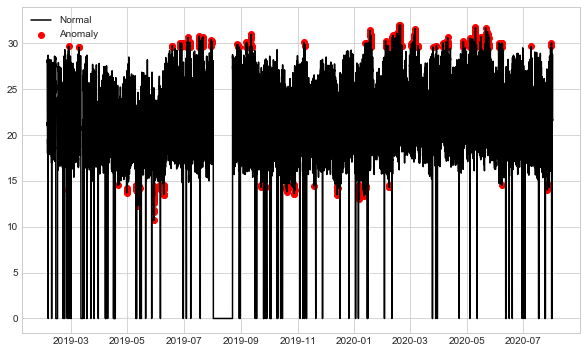

In [15]:
fig, ax = plt.subplots(figsize=(10,6))
a = data.loc[data['anomaly'] == -1, ['temp']] #anomaly
ax.plot(data.index, data['temp'], color='black', label = 'Normal')
ax.scatter(a.index,a['temp'], color='red', label = 'Anomaly')
plt.legend()
plt.show()

## Predicción: fbprophet

In [ ]:
from fbprophet import Prophet

def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

data = pd.DataFrame()
data['ds'] = orig_data.index
data['y'] = orig_data.values

interval_width = 0.99
changepoint_range = 0.95

m = Prophet(daily_seasonality = False, yearly_seasonality = False,
            weekly_seasonality = False, seasonality_mode = 'additive',
            interval_width = interval_width,
            changepoint_range = changepoint_range)

m = m.fit(data)
pred = m.predict(data)
pred['fact'] = data['y'].reset_index(drop = True)

pred = detect_anomalies(pred)

print(np.count_nonzero(pred['anomaly'].values))

norm = pred[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper']].copy()

m.plot(norm)

fig, ax = plt.subplots(figsize=(10,6))
a = pred.loc[pred['anomaly'] != 0,['ds','fact']] #anomaly
ax.scatter(pred['ds'], pred['fact'], color='black', label = 'Normal')
ax.scatter(a['ds'],a['fact'], color='red', label = 'Anomaly')
ax.scatter(pred['ds'],pred['yhat'], color='cyan', label = 'Forecasted')
plt.legend()
plt.show()

## Agrupaciones
### K-Means

In [ ]:
from sklearn.cluster import KMeans

def getDistanceByPoint(data, model):
    """ Function that calculates the distance between a point and centroid of a cluster, 
            returns the distances in pandas series"""
    distance = []
    for i in range(0,len(data)):
        Xa = np.array(data.iloc[i][0])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.append(np.linalg.norm(Xa-Xb))
    return pd.Series(distance, index=data.index)

data = orig_data.copy()
outlier_frac = 0.05

n_cluster = range(1,20)

kmeans = [KMeans(n_clusters=i).fit(data.values) for i in n_cluster]
scores = [kmeans[i].score(data.values) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

labels = kmeans[7].predict(data.values)
uniq_elem, count_elem = np.unique(labels, return_counts=True)

clusters = np.asanyarray((uniq_elem,count_elem))

distance = getDistanceByPoint(data, kmeans[7])

num_outlier = int(outlier_frac*len(distance))

threshold = distance.nlargest(num_outlier).min()

data['anomaly'] = (distance >= threshold).astype(int)

fig, ax = plt.subplots(figsize=(10,6))
a = data.loc[data['anomaly'] == 1, ['temp']] #anomaly
ax.plot(data.index, data['temp'], color='black', label = 'Normal')
ax.scatter(a.index,a['temp'], color='red', label = 'Anomaly')
plt.legend()
plt.show()

### DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

data = orig_data.copy()

dbscan = DBSCAN(eps=0.05, min_samples=10).fit(data.values)
labels = dbscan.labels_
outlier_pos = np.where(labels == -1)[0] #indice

a = data.iloc[outlier_pos]


fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(data.index, data['temp'], color='black', label = 'Normal')
ax.scatter(a.index, a['temp'], color='red', label = 'Anomaly')
plt.legend()
plt.show()